# Analisis de la expansión del Coronavirus COVID-19

### Basado en: 
https://towardsdatascience.com/create-a-coronavirus-app-using-r-shiny-and-plotly-6a6abf66091d

### Repositorio de datos Johns Hopkins CSSE: 
https://github.com/CSSEGISandData/COVID-19

### Lectura de librerías

In [1]:
# ayuda a suprimir warnings
shhh <- suppressPackageStartupMessages

# instala y carga librerias
load.lib <- c('tidyverse','data.table','zoo')
install.lib <- load.lib[!load.lib %in% installed.packages()]
for(libs in install.lib) install.packages(libs, dependences = TRUE)

load.mess <- shhh(sapply(load.lib, require, character = TRUE))

options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"Warning message:
"package 'data.table' was built under R version 3.6.3"

### Obtención de datos y fusión de tablas

In [2]:
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"

minutesSinceLastUpdate = function(fileName) {
  (as.numeric(as.POSIXlt(Sys.time())) - as.numeric(file.info(fileName)$ctime)) / 60
}

loadData = function(fileName, columnName) {
  if(!file.exists(fileName) || minutesSinceLastUpdate(fileName) > 60) {
    data = read.csv(file.path(baseURL, fileName), check.names=FALSE, stringsAsFactors=FALSE) %>%
      select(-Lat, -Long) %>% 
      pivot_longer(-(1:2), names_to="date", values_to=columnName) %>% 
      mutate(
        date=as.Date(date, format="%m/%d/%y"),
        `Country/Region`=if_else(`Country/Region` == "", "?", `Country/Region`),
        `Province/State`=if_else(`Province/State` == "", "<all>", `Province/State`)
      )
    save(data, file=fileName)  
  } else {
    load(file=fileName)
  }
  return(data)
}

allData = 
  loadData(
    "time_series_covid19_confirmed_global.csv", "CumConfirmed") %>%
  inner_join(loadData(
    "time_series_covid19_deaths_global.csv", "CumDeaths")) %>%
  inner_join(loadData(
    "time_series_covid19_recovered_global.csv","CumRecovered"))

Joining, by = c("Province/State", "Country/Region", "date")
Joining, by = c("Province/State", "Country/Region", "date")


### Cálculo de casos por día

In [3]:
# renombra columnas
colnames(allData) <- c('ProvState','Country','date','CumConfirmed','CumDeaths','CumRecovered')

# define nuevas columnas
data <- transform(allData, NewConfirmed=CumConfirmed - lag(CumConfirmed, default=0),
                           NewRecovered=CumRecovered - lag(CumRecovered, default=0),
                           NewDeaths=CumDeaths - lag(CumDeaths, default=0))

# define subconjunto para ProvState=="<all>"
data <- subset(data,ProvState=="<all>")

# define data.table
str(setDT(data))

Classes 'data.table' and 'data.frame':	14299 obs. of  9 variables:
 $ ProvState   : chr  "<all>" "<all>" "<all>" "<all>" ...
 $ Country     : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ date        : Date, format: "2020-01-22" "2020-01-23" ...
 $ CumConfirmed: int  0 0 0 0 0 0 0 0 0 0 ...
 $ CumDeaths   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ CumRecovered: int  0 0 0 0 0 0 0 0 0 0 ...
 $ NewConfirmed: num  0 0 0 0 0 0 0 0 0 0 ...
 $ NewRecovered: num  0 0 0 0 0 0 0 0 0 0 ...
 $ NewDeaths   : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


### Alizamiento de series temporales

https://www.displayr.com/smoothing-time-series-data/

In [4]:
# Paises a analizar
data0 <- subset(data,Country=="Peru" | Country=="Brazil" | Country=="Italy" | Country=="Japan")

# Calculo de medias moviles
data0 <- data0 %>% group_by(Country)%>%
         mutate(NewConfirmedMA = rollapply(NewConfirmed,7,mean,align='right',fill=NA),
                NewDeathsMA = rollapply(NewDeaths,7,mean,align='right',fill=NA))

### Gráficos de muertes

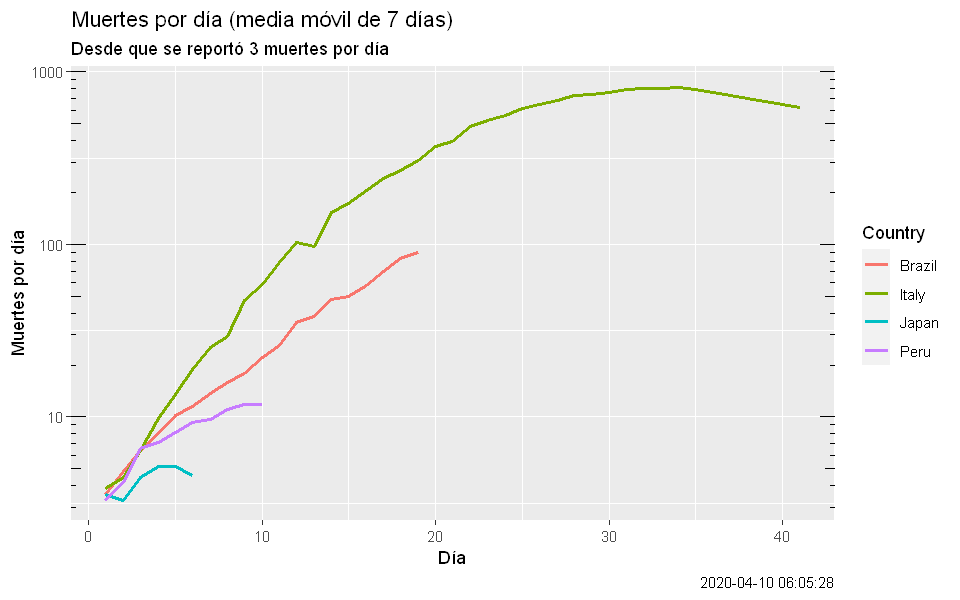

In [5]:
# Inicio de la figura
startDeath1 <- 3

data1 <- subset(data0, NewDeathsMA >= startDeath1)

# Enumeracion de datos
data1 <- data1 %>% group_by(Country) %>% mutate(Dias = row_number())

# define tamano de la figura
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data1, aes(x = Dias)) +
#       geom_line(aes(y = NewDeaths, colour = Country), linetype="dashed") + geom_point(aes(y = NewDeaths, colour = Country)) +
       geom_line(aes(y = NewDeathsMA, colour = Country), size = 1) +
       labs(title = "Muertes por día (media móvil de 7 días)", subtitle = "Desde que se reportó 3 muertes por día", x = "Día", y = "Muertes por día") +
       scale_y_log10() +
       annotation_logticks(sides = "lr") + 
       labs(caption = paste(Sys.time())) + 
       theme_grey()

Warning message:
"Removed 25 row(s) containing missing values (geom_path)."Warning message:
"Removed 12 row(s) containing missing values (geom_path)."Warning message:
"Removed 3 row(s) containing missing values (geom_path)."

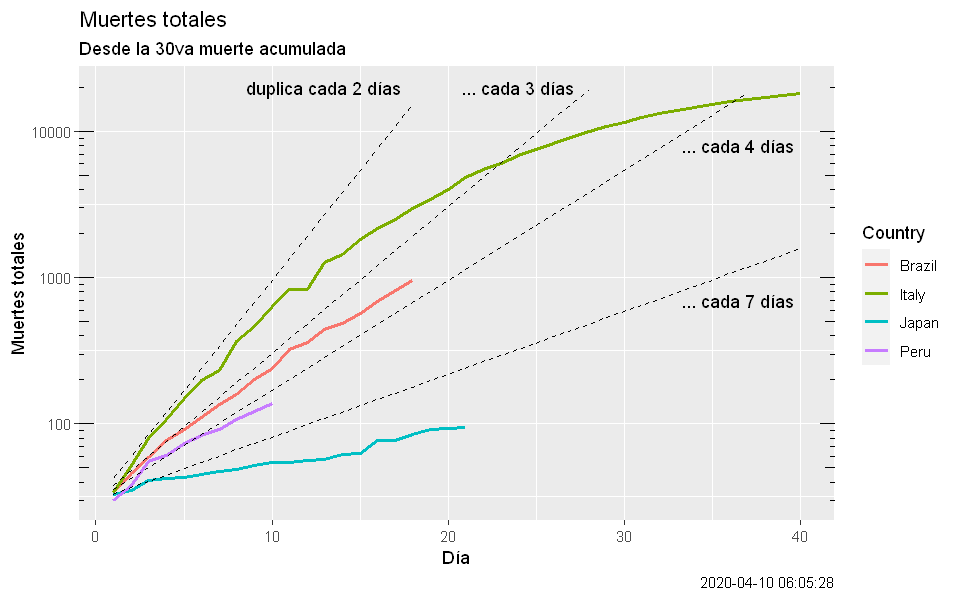

In [6]:
# Inicio de la figura
startDeath2 <- 30

data2 <- subset(data0, CumDeaths >= startDeath2)

# Enumeracion de datos
data2 <- data2 %>% group_by(Country) %>% mutate(Dias = row_number())

# Lineas de referencia
data2$dosdias <- startDeath2 * 2^(data2$Dias/2)
data2$tresdias <- startDeath2 * 2^(data2$Dias/3)
data2$cuatrodias <- startDeath2 * 2^(data2$Dias/4)
data2$sietedias <- startDeath2 * 2^(data2$Dias/7)

# define tamano de la figura
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data2, aes(x = Dias)) +
       geom_line(aes(y = CumDeaths, colour = Country), size = 1) + 
       geom_line(aes(y = dosdias), linetype = "dashed") + geom_line(aes(y = tresdias), linetype = "dashed") + 
       geom_line(aes(y = cuatrodias), linetype = "dashed") + geom_line(aes(y = sietedias), linetype = "dashed") +
       labs(title = "Muertes totales", subtitle = "Desde la 30va muerte acumulada", x = "Día", y = "Muertes totales") + 
       scale_y_log10(limits = c(startDeath2, 20000)) +
       annotation_logticks(sides = "lr") + 
       annotate(geom = "text", x = 13, y = 20000, label = "duplica cada 2 días") + 
       annotate(geom = "text", x = 24, y = 20000, label = "... cada 3 días") + 
       annotate(geom = "text", x = 36.5, y = 8000, label = "... cada 4 días") + 
       annotate(geom = "text", x = 36.5, y = 700, label = "... cada 7 días") + 
       labs(caption = paste(Sys.time())) + 
       theme_grey()

### Gráficos de infectados

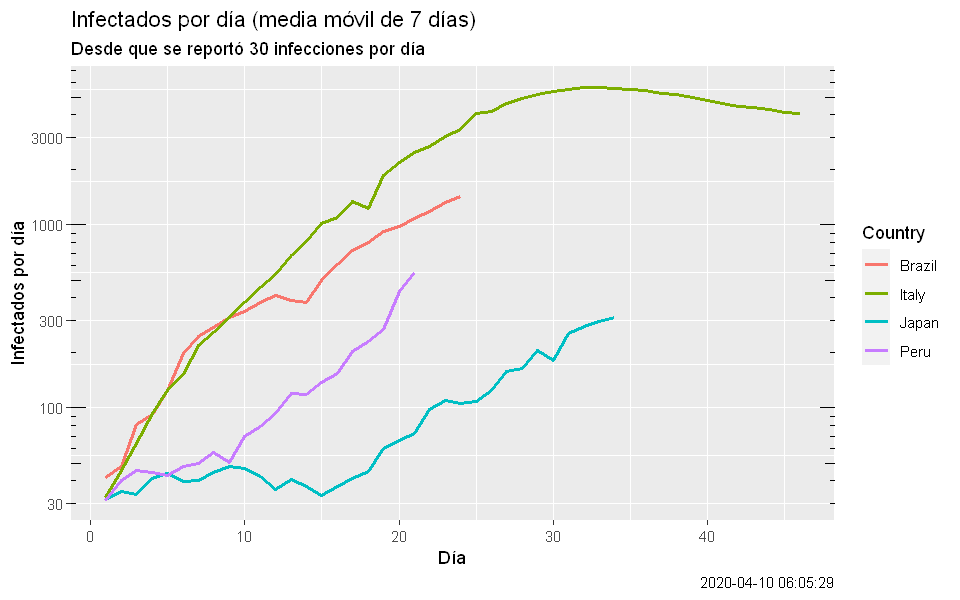

In [7]:
# Inicio de la figura
startConfirmed1 <- 30

data3 <- subset(data0, NewConfirmedMA >= startConfirmed1)

# Enumeracion de datos
data3 <- data3 %>% group_by(Country) %>% mutate(Dias = row_number())

# define tamano de la figura
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data3, aes(x = Dias)) +
#       geom_line(aes(y = NewConfirmed, colour = Country), linetype="dotted") + geom_point(aes(y = NewConfirmed, colour = Country)) +
       geom_line(aes(y = NewConfirmedMA, colour = Country), size = 1) + 
       labs(title = "Infectados por día (media móvil de 7 días)", subtitle = "Desde que se reportó 30 infecciones por día", x = "Día", y = "Infectados por día") +
       scale_y_log10() +
       annotation_logticks(sides = "lr") + 
       labs(caption = paste(Sys.time())) + 
       theme_grey()

Warning message:
"Removed 61 row(s) containing missing values (geom_path)."Warning message:
"Removed 27 row(s) containing missing values (geom_path)."Warning message:
"Removed 5 row(s) containing missing values (geom_path)."

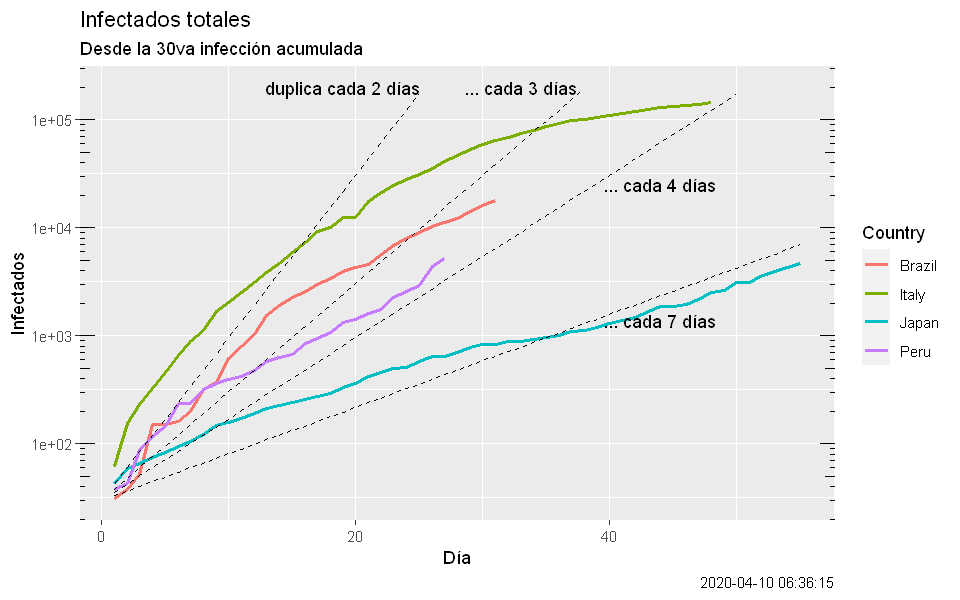

In [9]:
# Inicio de la figura
startConfirmed2 <- 30

data4 <- subset(data0, CumConfirmed >= startConfirmed2)

# Enumeracion de datos
data4 <- data4 %>% group_by(Country) %>% mutate(Dias = row_number())

# Lineas de referencia
data4$dosdias <- startConfirmed2 * 2^(data4$Dias/2)
data4$tresdias <- startConfirmed2 * 2^(data4$Dias/3)
data4$cuatrodias <- startConfirmed2 * 2^(data4$Dias/4)
data4$sietedias <- startConfirmed2 * 2^(data4$Dias/7)

# define tamano de la figura
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data4, aes(x = Dias)) + 
       geom_line(aes(y = CumConfirmed, colour = Country), size = 1) + 
       labs(title = "Infectados totales", subtitle = "Desde la 30va infección acumulada", x = "Día", y = "Infectados") + 
       geom_line(aes(y = dosdias), linetype = "dashed") + geom_line(aes(y = tresdias), linetype = "dashed") + 
       geom_line(aes(y = cuatrodias), linetype = "dashed") + geom_line(aes(y = sietedias), linetype = "dashed") +
       scale_y_log10(limits = c(startConfirmed2, 200000)) +
       annotation_logticks(sides = "lr") + 
       annotate(geom = "text", x = 19, y = 200000, label = "duplica cada 2 días") + 
       annotate(geom = "text", x = 33, y = 200000, label = "... cada 3 días") + 
       annotate(geom = "text", x = 44, y = 25000, label = "... cada 4 días") + 
       annotate(geom = "text", x = 44, y = 1400, label = "... cada 7 días") + 
       labs(caption = paste(Sys.time())) + 
       theme_grey()